In [1]:
import pandas as pd
import numpy as np
import pickle as p

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)
#tf.enable_eager_execution()
from sklearn.model_selection import train_test_split

from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

Compile the training data

In [ ]:
meta_data = pd.read_csv('/home/ec2-user/training_data_meta.csv')

#Join cleaned class data with training metadata

class_data = pd.read_csv('/home/ec2-user/stanford_labels_cleaned.csv')

meta_data = pd.merge(meta_data, class_data, on = 'class', how = 'left')

meta_data = meta_data.loc[meta_data['Body Type'].isin(['Coupe', 'Sedan'])].copy()

meta_data['is_sedan_target'] = (meta_data['Body Type'] == 'Sedan').astype(int)

image_dict = p.load(open('/home/ec2-user/scaled_bounded_grayscale_dict.p', 'rb'))

training_data = []
for i in meta_data[['is_sedan_target', 'fname']].iterrows():
    row = [i[1]['is_sedan_target']]
    row.extend(image_dict[i[1]['fname']].flatten())
    training_data.append(row)

training_data = np.array(training_data).astype(float)

Prep the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(training_data[:,1:], 
                                                    training_data[:,0], 
                                                    test_size=0.30, 
                                                    random_state=420)

y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

negatives = []
for ind, elem in enumerate(y_train):
    if elem == 0:
        negatives.append(ind)
np.random.shuffle(negatives)

neg_dupe_target = 2 * y_train.sum() - y_train.shape[0]

X_train = np.concatenate([X_train, X_train[negatives[0:neg_dupe_target],:]],
                         axis = 0
                        )
y_train = np.concatenate([y_train, y_train[negatives[0:neg_dupe_target]]],
                         axis = 0
                        )

y_train = np.concatenate([1 - y_train.reshape(-1,1), y_train.reshape(-1,1)], axis = 1)
y_test = np.concatenate([1 - y_test.reshape(-1,1), y_test.reshape(-1,1)], axis = 1)

Define the model

In [33]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    if type(features) is dict:
        features = features['input']
    #Define model architecture
    
    # Input Layer
    # Reshape X to 4-D tensor: [batch_size, width, height, channels]
    input_layer = tf.reshape(features, [-1, 200, 200, 1])

    # Convolutional Layer #1
    # Computes 32 features using a 3x3 filter with ReLU activation.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 200, 200, 1]
    # Output Tensor Shape: [batch_size, 200, 200, 32]
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu)

    # Pooling Layer #1
    # First max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 200, 200, 32]
    # Output Tensor Shape: [batch_size, 100, 100, 32]
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2
    # Computes 64 features using a 3x3 filter.
    # Padding is added to preserve width and height.
    # Input Tensor Shape: [batch_size, 100, 100, 32]
    # Output Tensor Shape: [batch_size, 100, 100, 64]
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=32,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu)

    # Pooling Layer #2
    # Second max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 100, 100, 64]
    # Output Tensor Shape: [batch_size, 50, 50, 64]
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    
    conv3 = tf.layers.conv2d(
      inputs=pool2,
      filters=64,
      kernel_size=[3, 3],
      padding="same",
      activation=tf.nn.relu)

    # Pooling Layer #3
    # Second max pooling layer with a 2x2 filter and stride of 2
    # Input Tensor Shape: [batch_size, 50, 50, 64]
    # Output Tensor Shape: [batch_size, 25, 25, 64]
    pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)

    # Flatten tensor into a batch of vectors
    # Input Tensor Shape: [batch_size, 25, 25, 64]
    # Output Tensor Shape: [batch_size, 25 * 25 * 64]
    pool3_flat = tf.reshape(pool3, [-1, 25 * 25 * 64])

    # Dense Layer
    # Densely connected layer with 256 neurons
    # Input Tensor Shape: [batch_size, 25 * 25 * 64]
    # Output Tensor Shape: [batch_size, 256]
    dense = tf.layers.dense(inputs=pool3_flat, units=256, activation=tf.nn.relu)

    # Add dropout operation; 0.6 probability that element will be kept
    dropout = tf.layers.dropout(
      inputs=dense, rate=0.5, training=(mode == tf.estimator.ModeKeys.TRAIN))

    # Logits layer
    # Input Tensor Shape: [batch_size, 1024]
    # Output Tensor Shape: [batch_size, 10]
    logits = tf.layers.dense(inputs=dropout, units=2)
    
    #Predict Op
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            # Generate predictions (for PREDICT and EVAL mode)
            "classes": tf.argmax(input=logits, axis=1),
            # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
            # `logging_hook`.
            "probabilities": tf.nn.softmax(logits, name="softmax_tensor"),
            "logits" : logits
            
        }
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        #Define model outputs
        # Calculate Loss (for both TRAIN and EVAL modes)
        loss = tf.losses.sparse_softmax_cross_entropy(labels=labels[:,1], logits=logits)
        
        logging_hook = tf.train.LoggingTensorHook(
            {"loss" : loss,
            },
            every_n_iter=10)
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(
            mode=mode, loss=loss, train_op=train_op, training_hooks = [logging_hook])
    # Add evaluation metrics (for EVAL mode)
    if mode == tf.estimator.ModeKeys.EVAL:
        #Define model outputs
        # Calculate Loss (for both TRAIN and EVAL modes)
        loss = tf.losses.sparse_softmax_cross_entropy(labels=labels[:,1], logits=logits)
        
        predictions = {
          # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
          # `logging_hook`.
          "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
        }
        #swap this for AUROC?
        eval_metric_ops = {
          "eval_accuracy": tf.metrics.auc(
              labels=labels, predictions=predictions["probabilities"])}

        return tf.estimator.EstimatorSpec(
          mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [34]:
session_config = tf.ConfigProto(
      inter_op_parallelism_threads=32,
      intra_op_parallelism_threads=32,
      )

config = tf.estimator.RunConfig(session_config = session_config,
                                log_step_count_steps = 10,
                                save_summary_steps = 10
                               )

# Create the Estimator
car_classifier = tf.estimator.Estimator(
  model_fn=cnn_model_fn, model_dir="/home/ec2-user/convnet_model", config = config)

INFO:tensorflow:Using config: {'_model_dir': '/home/ec2-user/convnet_model', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': intra_op_parallelism_threads: 32
inter_op_parallelism_threads: 32
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 10, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f75357b5d68>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [35]:
#custom input function using training_image_processor with tf.data.Dataset
def image_processor_train_input_fn(image_processor, X_train, y_train, batch_size):
    
    dataset = tf.data.Dataset.from_generator(
        generator = lambda : image_processor.flow(X_train.reshape((X_train.shape[0], 200, 200, 1)), 
                                                  y_train, batch_size, shuffle = True), 
        output_types = (np.float32, np.int32))
    
    dataset = dataset.shuffle(512).repeat()
    
    return dataset

def image_processor_eval_input_fn(X_test, y_test, batch_size):
    
    dataset = tf.data.Dataset.from_tensor_slices((X_test.astype('float32') / 255.0, 
                                                  y_test.astype('int32')))
        
    return dataset.batch(batch_size)

#Shearing, no zooming
training_image_processor = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale= 1./255,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range=15,
    horizontal_flip=True,
    data_format = 'channels_last',
)

Train

In [13]:
car_classifier.train(
      input_fn=lambda:image_processor_train_input_fn(training_image_processor, X_train, y_train, 128),
      steps=1000
    )

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/ec2-user/convnet_model/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2000 into /home/ec2-user/convnet_model/model.ckpt.
INFO:tensorflow:loss = 0.3248356, step = 2001
INFO:tensorflow:loss = 0.3248356
INFO:tensorflow:global_step/sec: 0.253579
INFO:tensorflow:loss = 0.3441033, step = 2011 (39.437 sec)
INFO:tensorflow:loss = 0.3441033 (39.436 sec)
INFO:tensorflow:global_step/sec: 0.302291
INFO:tensorflow:loss = 0.2703493, step = 2021 (33.080 sec)
INFO:tensorflow:loss = 0.2703493 (33.080 sec)
INFO:tensorflow:global_step/sec: 0.305158
INFO:tensorflow:loss = 0.41520917, step = 2031 (32.770 sec)
INFO:tensorflow:loss = 0.41520917 (32.770 sec)
INFO:tensorflow:global_step/sec: 0.307353
INFO:tensorflow:loss =

KeyboardInterrupt: 

Evaluate Performance

In [36]:
print('training error')
eval_results = car_classifier.evaluate(
    input_fn=lambda:image_processor_eval_input_fn(X_train, y_train, 32))
print(eval_results)

print('testing error')
eval_results = car_classifier.evaluate(
    input_fn=lambda:image_processor_eval_input_fn(X_test, y_test, 32))
print(eval_results)

training error
Instructions for updating:
Colocations handled automatically by placer.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-04-06T21:14:31Z
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /home/ec2-user/convnet_model/model.ckpt-10003
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-04-06-21:15:43
INFO:tensorflow:Saving dict for global step 10003: ev

Run inference

In [37]:
predicted_classes = car_classifier.predict(
    input_fn=lambda:image_processor_eval_input_fn(X_test, y_test, 32))

testing_analysis = []

for pred, label in zip(predicted_classes, y_test):
    hold = [pred['probabilities'][1], pred['classes'], label[1], pred['logits'][0], pred['logits'][1]]
    testing_analysis.append(hold)
    
testing_analysis = pd.DataFrame(testing_analysis, columns = ['prob', 'class', 'label', 'logit_0', 'logit_1'])
testing_analysis['logit_1_decile'] = pd.qcut(testing_analysis.logit_1, 10, labels = False)
testing_analysis['logit_0_decile'] = pd.qcut(testing_analysis.logit_0, 10, labels = False)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/ec2-user/convnet_model/model.ckpt-10003
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [38]:
testing_analysis.groupby(['logit_1_decile', 'label'])['class'].value_counts()

logit_1_decile  label  class
0               0      0        101
                1      0          8
1               0      0         92
                1      0         16
2               0      0         82
                1      0         27
3               0      0         58
                1      0         47
                       1          3
4               0      0         37
                       1         13
                1      0         40
                       1         19
5               0      1         22
                       0          4
                1      1         75
                       0          7
6               0      1         29
                1      1         79
7               0      1         10
                1      1         99
8               0      1          5
                1      1        103
9               0      1          3
                1      1        106
Name: class, dtype: int64

In [39]:
testing_analysis.groupby(['logit_0_decile', 'label'])['class'].value_counts()

logit_0_decile  label  class
0               1      1        109
1               0      1          9
                1      1         99
2               0      1         11
                1      1         98
3               0      1         18
                1      1         90
4               0      1         30
                       0          4
                1      1         73
                       0          2
5               0      0         40
                       1         13
                1      0         40
                       1         15
6               0      0         59
                       1          1
                1      0         48
7               0      0         77
                1      0         32
8               0      0         92
                1      0         16
9               0      0        102
                1      0          7
Name: class, dtype: int64

In [40]:
testing_analysis.groupby('label')['class'].value_counts()

label  class
0      0        374
       1         82
1      1        484
       0        145
Name: class, dtype: int64

In [ ]:
for i in testing_analysis.loc[testing_analysis.logit_1_decile == 9].index[0:20]:
    plt.figure()
    row = testing_analysis.iloc[i]
    plt.title('class %f label %f'%(row['class'], row['label']))
    imshow(Image.fromarray((X_test[i,:].reshape((200,200))).astype('uint8'), mode = 'L'))

SUVs and Verts

In [18]:
meta_data = pd.read_csv('/home/ec2-user/training_data_meta.csv')

#Join cleaned class data with training metadata

class_data = pd.read_csv('/home/ec2-user/stanford_labels_cleaned.csv')

meta_data = pd.merge(meta_data, class_data, on = 'class', how = 'left')

meta_data = meta_data.loc[meta_data['Body Type'].isin(['SUV', 'Convertible'
                                                      ])].copy()

meta_data['is_sedan_target'] = (meta_data['Body Type'] == 'SUV').astype(int)

image_dict = p.load(open('/home/ec2-user/scaled_bounded_grayscale_dict.p', 'rb'))

oot_data = []
for i in meta_data[['is_sedan_target', 'fname']].iterrows():
    row = [i[1]['is_sedan_target']]
    row.extend(image_dict[i[1]['fname']].flatten())
    oot_data.append(row)

oot_data = np.array(oot_data).astype(float)

In [19]:
X_oot = oot_data[:,1:]

y_oot = oot_data[:,0].astype('int32')
y_oot = np.concatenate([1 - y_oot.reshape(-1,1), y_oot.reshape(-1,1)], axis = 1)

In [20]:
print('oot error')
eval_results = car_classifier.evaluate(
    input_fn=lambda:image_processor_eval_input_fn(X_oot, y_oot, 32))
print(eval_results)

oot error
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-03-21T15:51:47Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/ec2-user/convnet_model/model.ckpt-5653
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-03-21-15:52:17
INFO:tensorflow:Saving dict for global step 5653: eval_accuracy = 0.82551754, global_step = 5653, loss = 0.80654323
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5653: /home/ec2-user/convnet_model/model.ckpt-5653
{'eval_accuracy': 0.82551754, 'loss': 0.80654323, 'global_step': 5653}


In [23]:
predicted_classes = car_classifier.predict(
    input_fn=lambda:image_processor_eval_input_fn(X_oot, y_oot, 32))

testing_analysis = []

for pred, label in zip(predicted_classes, y_oot):
    hold = [pred['probabilities'][1], pred['classes'], label[1], pred['logits'][0], pred['logits'][1]]
    testing_analysis.append(hold)
    
testing_analysis = pd.DataFrame(testing_analysis, columns = ['prob', 'class', 'label', 'logit_0', 'logit_1'])
testing_analysis['logit_1_decile'] = pd.qcut(testing_analysis.logit_1, 10, labels = False)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/ec2-user/convnet_model/model.ckpt-5653
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [24]:
testing_analysis.groupby(['logit_1_decile', 'label'])['class'].value_counts()

logit_1_decile  label  class
0               0      0        231
                1      0         29
1               0      0        196
                1      0         63
2               0      0        160
                1      0         97
                       1          2
3               0      1         82
                       0         40
                1      1        104
                       0         34
4               0      1        113
                1      1        146
5               0      1         68
                1      1        191
6               0      1         49
                1      1        211
7               0      1         40
                1      1        219
8               0      1         30
                1      1        229
9               0      1         27
                1      1        233
Name: class, dtype: int64

In [25]:
testing_analysis.groupby('label')['class'].value_counts()

label  class
0      0         627
       1         409
1      1        1335
       0         223
Name: class, dtype: int64

In [ ]:
for i in testing_analysis.loc[testing_analysis.logit_1_decile == 3].index[0:20]:
    plt.figure()
    row = testing_analysis.iloc[i]
    plt.title('class %f label %f'%(row['class'], row['label']))
    imshow(Image.fromarray((X_oot[i,:].reshape((200,200))).astype('uint8'), mode = 'L'))

Train and Evaluate

In [9]:
train_spec = tf.estimator.TrainSpec(
     input_fn=lambda:image_processor_train_input_fn(
         training_image_processor, X_train, y_train, 32), 
     max_steps=4100)


eval_spec = tf.estimator.EvalSpec(
    input_fn=lambda:image_processor_eval_input_fn(X_train, y_train, 32)
)

In [11]:
evaluate_results = tf.estimator.train_and_evaluate(car_classifier, train_spec, eval_spec)

INFO:tensorflow:Not using Distribute Coordinator.
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
INFO:tensorflow:Skipping training since max_steps has already saved.


Export to SavedModel

In [24]:
def serving_input_receiver_fn():
    inputs = {
        'input' : tf.placeholder(tf.float32, [None, 200, 200, 1]),
    }
    
    inputs['input'] = tf.divide(inputs['input'], 255.0)
    return tf.estimator.export.ServingInputReceiver(inputs, inputs)


In [26]:
car_classifier.export_savedmodel('/home/ec2-user/convnet_saved_model/', serving_input_receiver_fn,
                            strip_default_attrs=True)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from /home/ec2-user/convnet_model/model.ckpt-4100
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /home/ec2-user/convnet_saved_model/temp-b'1553120111'/saved_model.pb


b'/home/ec2-user/convnet_saved_model/1553120111'

Invoke SGM Endpoint

In [5]:
import boto3

client = boto3.client('runtime.sagemaker', region_name = 'us-east-2')

In [6]:
data = []
for i in X_train:
    row = ''
    for j in i:
        scaled = j / 255
        row += f'{scaled},'
    data.append(row[:-1])
    break

In [10]:
response = client.invoke_endpoint(EndpointName='sagemaker-tensorflow-scriptmode-2019-04-07-18-20-33-352',
                                       ContentType='text/csv',
                                       Body=data[0])

In [11]:
hold = response['Body'].read().decode()

print(hold)

{
    "predictions": [
        {
            "probabilities": [0.210038, 0.789962],
            "logits": [-0.927644, 0.397055],
            "classes": 1
        }
    ]
}


In [70]:
local_pred = car_classifier.predict(
    input_fn=lambda:image_processor_eval_input_fn(X_train[0:2], y_train[0:2], 32))

for pred, label in zip(local_pred, y_train[0:2]):
    print(pred)
    print(label)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /home/ec2-user/convnet_model/model.ckpt-10003
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
{'classes': 1, 'probabilities': array([0.01318983, 0.9868102 ], dtype=float32), 'logits': array([-2.8551736,  1.4598585], dtype=float32)}
[0 1]
{'classes': 1, 'probabilities': array([1.9244720e-04, 9.9980754e-01], dtype=float32), 'logits': array([-5.697554,  2.857942], dtype=float32)}
[0 1]


In [78]:
X_train[0].shape

(40000,)

In [80]:
X_train[1].reshape((200,200)).shape

(200, 200)

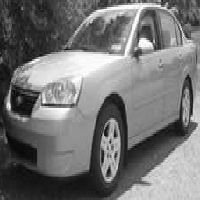

In [91]:
Image.fromarray(X_train[0].reshape((200,200)).astype('int8'), mode='L')

In [90]:
image_dict['00001.jpg']

array([[114, 113, 115, ..., 136, 101,  96],
       [113, 113, 115, ..., 138, 101, 101],
       [113, 113, 115, ..., 137,  94,  99],
       ...,
       [179, 174, 171, ...,  74, 158, 145],
       [175, 173, 175, ...,  98,  85, 166],
       [175, 175, 172, ...,  80, 106, 158]], dtype=uint8)